# Thinking like Xarray

**Deepak Cherian, CGD**

## Motivation / Learning goals

From https://toolz.readthedocs.io/en/latest/control.html
> The Toolz library contains dozens of patterns like map and groupby. Learning a core set (maybe a dozen) covers the vast majority of common programming tasks often done by hand.
> A rich vocabulary of core control functions conveys the following benefits:
>    - You identify new patterns
>    - You make fewer errors in rote coding
>    - You can depend on well tested and benchmarked implementations


The same is true for xarray

## Why xarray


Xarray allows you to leverage dataset metadata to write more readable analysis code. The metadata is stored with the data; not in your head.
1. Dimension names: `dim="latitude"` instead of `axis=0`
2. Coordinate "labels": or axis tick labels. `data.sel(latitude=45)` instead of `data[10]`


Xarray also provides high-level computational patterns that cover most data analysis tasks.

1. ``groupby``, ``groupby_bins``
2. ``resample``
3. ``rolling``
4. ``coarsen``
5. ``weighted``
6. ``differentiate``, ``integrate``

## Load example dataset

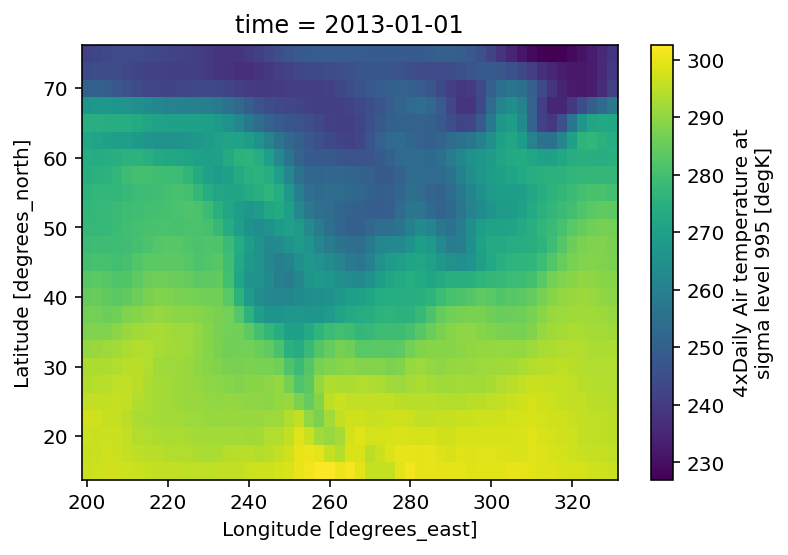

In [72]:
import xarray as xr
xr.set_options(display_style="text")

da = xr.tutorial.load_dataset("air_temperature").air
monthly = da.resample(time="M").mean()
data = da.isel(time=0)
data.plot()

## Concept: "Index" vs "Label" space operations

Consider `.isel` vs `sel`

In [ ]:
# index space
data[10, :]  # 10th element along the first axis; ¯\_(ツ)_/¯

# index space
data.isel(lat=10)  # slightly better, 10th element in latitude

# "label" space
data.sel(lat=50)  # much better! lat=75°N

In [ ]:
# What I wanted to do
data.sel(lat=50)

# What I had to do (if I wasn't using xarray)
data[10, :]

## Windowing Operations : index space

These are windowed operations with a window of a fixed size.

- ``rolling``: sliding window operations e.g. running mean
- ``coarsen``: decimating; reshaping

### Sliding windows of fixed length: ``rolling``

- returns object of same shape as input
- pads with NaNs to make this happen
- supports multiple dimensions

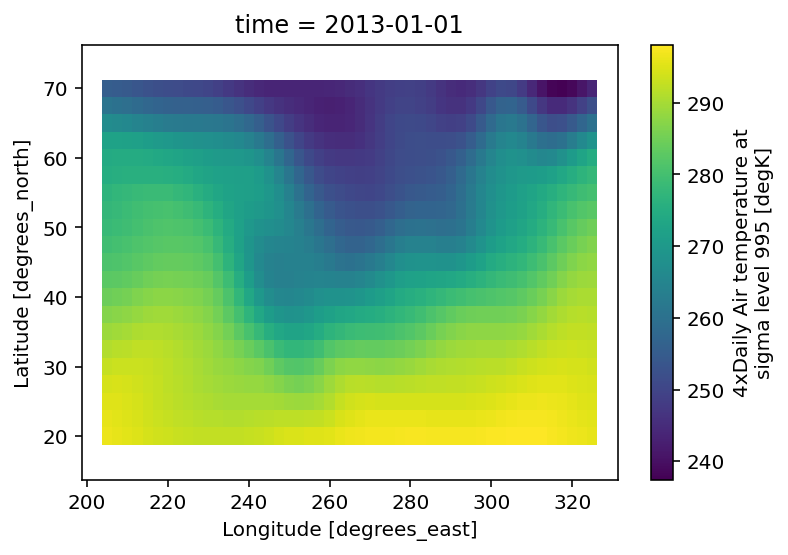

In [62]:
data.rolling(lat=5, lon=5, center=True).mean().plot()

#### Apply an existing numpy-only function with ``reduce``

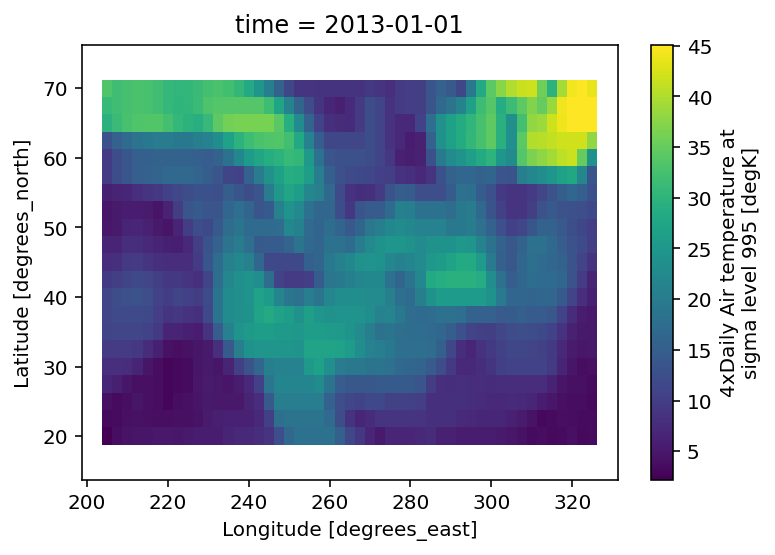

In [63]:
data.rolling(lat=5, lon=5, center=True).reduce(np.ptp).plot()

#### For more complicated analysis, construct a new array with a new dimension.
- Allows things like short-time fourier transform, spectrogram, windowed rolling etc.

``construct`` is clever. It constructs a **view** of the original array, so it is memory-efficient
- But you didn't have to know that

In [64]:
(
    ds.rolling(lat=5, lon=5, center=True)
    .construct(lat="lat_roll", lon="lon_roll")
)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, lat_roll: 5, lon_roll: 5)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Dimensions without coordinates: lat_roll, lon_roll
Data variables:
    air      (lat, lon, lat_roll, lon_roll) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Block windows of fixed length: ``coarsen``

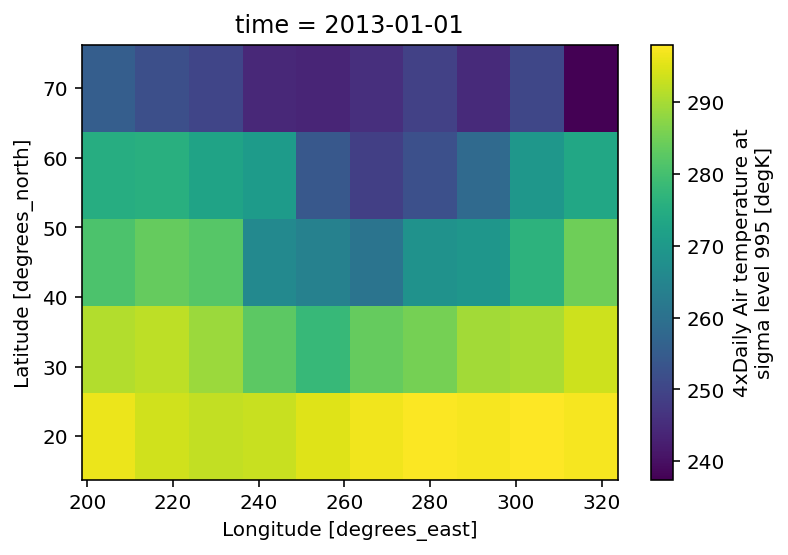

In [65]:
(
    data
    .coarsen(lat=5, lon=5, boundary="trim").mean()
    .plot()
)

#### coarsen supports ``reduce`` for custom reductions

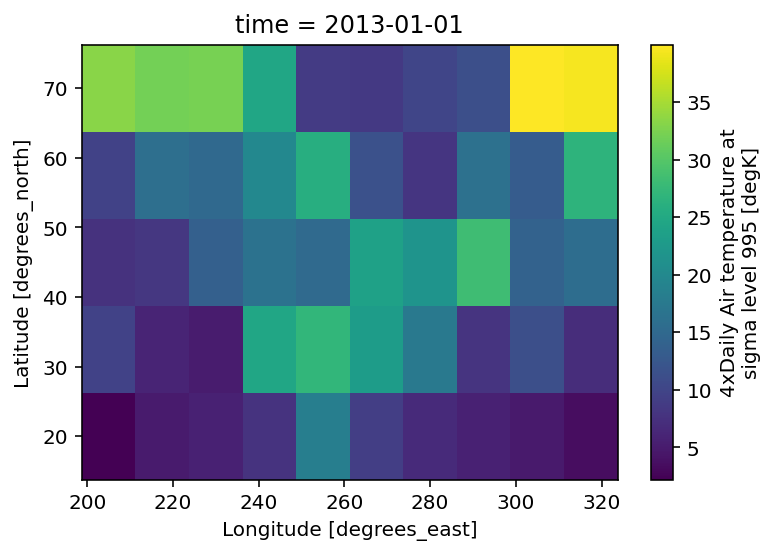

In [66]:
(
    data
    .coarsen(lat=5, lon=5, boundary="trim").reduce(np.ptp)
    .plot()
)

#### coarsen supports ``construct`` for block reshaping

In [81]:
# splits time dimension into year x month
year_month = monthly.coarsen(time=12).construct(time=("year", "month"))
year_month

<xarray.DataArray 'air' (year: 2, month: 12, lat: 25, lon: 53)>
array([[[[244.4667 , 244.66354, 244.67027, ..., 242.49142, 243.40633,
          244.67577],
         [247.07323, 247.02248, 246.7275 , ..., 240.58205, 242.04489,
          244.70726],
         [250.37941, 249.83484, 249.10748, ..., 241.98434, 244.76712,
          249.00505],
         ...,
         [295.83795, 295.15085, 294.9229 , ..., 295.36826, 294.88437,
          294.26828],
         [296.46942, 296.31686, 295.84802, ..., 295.5876 , 295.34058,
          294.86536],
         [297.05316, 297.0418 , 296.73517, ..., 296.30438, 296.09732,
          296.0389 ]],

        [[240.73384, 240.7013 , 240.4115 , ..., 241.60518, 242.71988,
          243.94455],
         [241.93309, 242.06935, 241.913  , ..., 241.01428, 242.32481,
          244.72758],
         [245.32361, 245.0261 , 244.36955, ..., 243.41588, 245.7661 ,
          249.65858],
...
         [298.04895, 297.35007, 297.22195, ..., 298.01172, 297.66013,
          297.14554],
         [298.96484, 298.81186, 298.27136, ..., 298.10403, 298.22104,
          297.88547],
         [299.17334, 299.2175 , 298.89566, ..., 298.71625, 298.74167,
          298.7802 ]],

        [[246.80156, 246.88907, 246.76907, ..., 240.07089, 241.08206,
          242.2817 ],
         [247.72998, 248.30064, 248.74443, ..., 238.61859, 240.3222 ,
          242.97026],
         [249.96893, 249.58516, 249.57521, ..., 237.70308, 241.23743,
          246.22667],
         ...,
         [296.4491 , 295.6914 , 295.75824, ..., 296.52817, 296.21747,
          295.8128 ],
         [297.44586, 297.43613, 297.1817 , ..., 296.95242, 297.05823,
          296.72897],
         [298.0472 , 298.22598, 298.0595 , ..., 297.6975 , 297.72318,
          297.71024]]]], dtype=float32)
Coordinates:
    time     (year, month) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Dimensions without coordinates: year, month

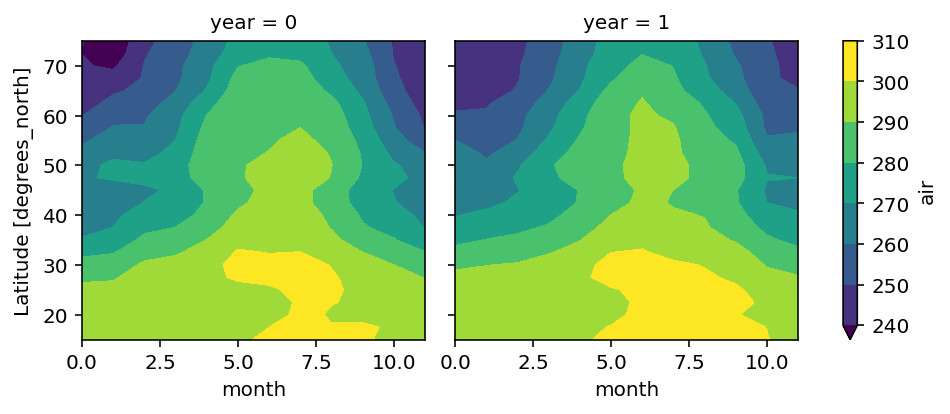

In [89]:
# seasonal cycle for two years
year_month.sel(lon=250).plot.contourf(col="year", x="month", y="lat", robust=True)

## Grouping operations : label space

Generalization of ``coarsen``: sometimes the windows you want are not regular.

- ``groupby``: works when "groups" are exact: e.g. characters or integers; not floats
- ``groupby_bins``: binning operations
- ``resample``: groupby but specialized for time grouping (so far)


## Concept: Alignment